# Imports

In [1]:
# Data
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Stats
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
import optuna
# ML
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import xgboost as xgb
import gpboost as gpb
# DL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Misc
from tqdm import tqdm
from typing import Any, Tuple, Optional, List, Union, Dict # type tips
import warnings
from itertools import combinations
import logging
import os
import pickle


# Functions

In [6]:
def create_train_test_split(data: pd.DataFrame, target: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Creates train/test splits for time series data on a per-participant basis.
    
    For each participant (PID):
    1. Finds their last day of data collection based on target variable
    2. Removes any data after their last valid day
    3. Creates an 80/20 chronological train/test split
    
    Args:
        data: DataFrame containing participant data with columns:
            - PID: Participant ID
            - day: Day number of study
            - target: Target variable to determine last valid day
        target: Name of target variable column
            
    Returns:
        tuple containing:
            - train_data: DataFrame with first 80% of each participant's data
            - test_data: DataFrame with last 20% of each participant's data
    """
    # Get last day of data collection for each PID based on target variable
    last_days = data.groupby('PID').agg({
        'day': lambda x: x[data[target].notna()].max()
    }).reset_index()

    # Remove any data after each PID's last day
    tt_filtered = pd.merge(
        data,
        last_days,
        on='PID',
        suffixes=('', '_last')
    )
    tt_filtered = tt_filtered[tt_filtered['day'] <= tt_filtered['day_last']]
    
    # Create train/test splits for each PID
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    for pid in tt_filtered['PID'].unique():
        pid_data = tt_filtered[tt_filtered['PID'] == pid].copy()
        
        # Sort by day to ensure chronological split
        pid_data = pid_data.sort_values('day')
        
        # Calculate split point at 80%
        split_idx = int(len(pid_data) * 0.8)
        
        # Split the data
        train_pid = pid_data.iloc[:split_idx]
        test_pid = pid_data.iloc[split_idx:]
        
        # Append to main dataframes
        train_data = pd.concat([train_data, train_pid])
        test_data = pd.concat([test_data, test_pid])
        
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [7]:
# Function to detrend a single column
def detrend_column(group):
    """Detrend a single column while preserving its mean level.
    
    Args:
        group: pandas Series containing the data to detrend
        
    Returns:
        pandas Series with trend removed but original mean preserved
    """
    X = np.arange(len(group))
    X_poly = np.column_stack((X, X**2, X**3))
    
    # Remove NaN and infinite values
    mask = ~np.isnan(group) & ~np.isinf(group)
    X_clean = X_poly[mask]
    y_clean = group[mask]
    
    if len(y_clean) > 0:
        # Store original mean
        original_mean = y_clean.mean()
        
        # Fit trend
        model = LinearRegression().fit(X_clean, y_clean)
        trend = np.full(len(group), np.nan)
        trend[mask] = model.predict(X_clean)
        
        # Remove trend and add back original mean
        detrended = group - trend
        detrended[mask] = detrended[mask] + original_mean
        
        return detrended
    else:
        return group  # Return original if all values are NaN or infinite

In [8]:
def create_aggregated_features(train_data: pd.DataFrame, 
                             test_data: pd.DataFrame, 
                             features: list,
                             target: str = None,
                             agg_funcs: list = ['median', 'std']) -> tuple[pd.DataFrame, pd.DataFrame, list]:
    """
    Creates aggregated features (e.g. median, std) per participant and adds them to the data.
    
    Args:
        train_data: Training DataFrame containing participant data
        test_data: Test DataFrame containing participant data  
        features: List of feature names to aggregate
        target: Optional target variable name to include in aggregation
        agg_funcs: List of aggregation functions to apply. Defaults to ['median', 'std']
    
    Returns:
        tuple containing:
            - Modified training data with aggregated features
            - Modified test data with aggregated features 
            - Updated list of features including new aggregated feature names
    """
    # Create copy of input data
    train_data = train_data.copy()
    test_data = test_data.copy()
    features = features.copy()
    
    # Filter features to exclude ID columns and non-numeric columns
    numeric_features = train_data[features].select_dtypes(include=['int64', 'float64']).columns
    agg_features = [f for f in numeric_features if 'fe' not in f]
    agg_features = [f for f in agg_features if 'weekend' not in f and 'day_of_week' not in f]
    
    # Add target if specified and is numeric
    if target is not None and pd.api.types.is_numeric_dtype(train_data[target]):
        agg_features.append(target)
    
    # Calculate aggregated stats for each PID
    pid_stats = train_data.groupby('PID')[agg_features].agg(agg_funcs).reset_index()
    
    # Flatten multi-level column names with 'agg_' prefix
    pid_stats.columns = ['PID'] + [f'agg_{col[0]}_{col[1]}' for col in pid_stats.columns[1:]]
    
    # Merge stats back to train and test data
    train_data = train_data.merge(pid_stats, on='PID', how='left')
    test_data = test_data.merge(pid_stats, on='PID', how='left')
    
    # Add new feature names to features list
    for f in agg_features:
        for func in agg_funcs:
            features.append(f'agg_{f}_{func}')
    
    return train_data, test_data, features

In [9]:
def plot_model_diagnostics(actual_vals: np.ndarray, predicted_vals: np.ndarray, test_data_clean: pd.DataFrame) -> None:
    """
    Create diagnostic plots for model evaluation.
    
    Parameters
    ----------
    actual_vals : array-like
        The actual target values from the test set
    predicted_vals : array-like 
        The model's predictions for the test set
    test_data_clean : pd.DataFrame
        The cleaned test dataset containing PID column for coloring points
        
    Returns
    -------
    None
        Displays two plots:
        1. Distribution of prediction errors
        2. Actual vs predicted values scatter plot colored by participant
    """
    # Create visualization plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    
    # Plot 1: Error distribution
    errors = actual_vals - predicted_vals
    sns.histplot(data=errors, ax=ax1)
    ax1.axvline(x=0, color='red', linestyle='--')
    ax1.set_title('Distribution of Prediction Errors')
    ax1.set_xlabel('Error (Actual - Predicted)')
    ax1.set_ylabel('Count')
    
    # Plot 2: Actual vs Predicted
    sns.scatterplot(x=actual_vals, y=predicted_vals, ax=ax2, alpha=0.5, 
                    hue=test_data_clean['PID'], palette='viridis', legend=False)
    ax2.plot([actual_vals.min(), actual_vals.max()],
                [actual_vals.min(), actual_vals.max()],
                'r--')
    ax2.set_title('Actual vs Predicted Values')
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    
    plt.tight_layout()
    plt.show()

# Data

## Load Data

In [10]:
# df is the non-normalized passive data with features and target 
# df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/df_passive_fe.csv')
df = pd.read_csv('../../../3_3_2_processed_data/modeling/all_data/all_features.csv')
# Rename css column to task_css
df = df.rename(columns={'css': 'task_css'})


# mlm_gap_df is the results of the MLM on the gap data
mlm_gap_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_gap_results_df.csv')
mlm_affect_df = pd.read_csv('../../../3_3_2_processed_data/modeling/passive_data/mlm_affect_results_df.csv')

In [11]:
df_raw = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/df_good.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_39074/1744315639.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_3_data_analysis/02_analysis/df_good.csv')


**Add Cendri Hutcherson's calculated drift rate**
- Used ddm models to break down task performance by day and then averaged across tasks.

In [12]:
drift_df = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/modeling/DailyCogDDMMeasure.csv')
# Rename columns
drift_df = drift_df.rename(columns={
    'subj': 'PID',
    'date': 'trial_date',
    'allCogDTNormDDM2': 'task_drift'
})

drift_df = drift_df[['PID', 'trial_date', 'task_drift']]

# join drift_df to df
df = pd.merge(df, drift_df, on=['PID', 'trial_date'], how='left')

## Clean Data

In [13]:
# remove t_current
df = df.drop(columns=['t_current'])

# remove subject with wonky data
df = df[df['PID'] != 'c8b323ca-be8b-4374-ab2c-b4788e4a0e3d']

# remove any columns containing 'sr_gap_heuristic'
df = df.drop(columns=[col for col in df.columns if 'sr_gap_heuristic' in col])

## Data Subsets

### ID Features

In [14]:
# ID cols
id_cols = [
    'PID',
    #'trial_date',
    'day',
   # 'cohort',
    'weekend',
    'day_of_week_0',
    'day_of_week_1',
    'day_of_week_2',
    'day_of_week_3',
    'day_of_week_4',
    'day_of_week_5',
    'day_of_week_6',
    ]

### Passive Features

In [15]:
# Passive features
passive_cols = [col for col in df.columns if 'passive' in col]

# Additional cols
additional_passive_cols = [
    'task_duration',
    'task_start_time',
    'task_end_time',
    'survey_complete',
    'tasks_complete',
    'watch_wearing'
]

# Create df_passive
passive_cols = passive_cols + additional_passive_cols

### Affect Features


In [16]:
# Affect features
affect_cols = [col for col in df.columns if 'affect_' in col]
affect_pm_cols = [col for col in df.columns if 'affect_' in col and not col.endswith('_am')]

### Self Report Features

In [17]:
# create list of self report features
sr_cols = [col for col in df.columns if 'sr_' in col]

# remove affect self report features
sr_cols = [col for col in sr_cols if 'affect' not in col]

# remove social support features
sr_cols = [col for col in sr_cols if 'ss_' not in col]

# remove goal related features
sr_cols = [col for col in sr_cols if '_goal' not in col]

# List of self report features directly related to gap
gap_related_sr = [
    'sr_DAILY_past24_procrastination',
    'sr_DAILY_past24_productivity',
    'sr_DAILY_past24_punctuality',
    'sr_DAILY_past24_satisfaction',
    'sr_DAILY_past24_values',
    'sr_DAILY_past24_gapCause_internal',
    'sr_DAILY_past24_gapCause_external',
    'sr_DAILY_past24_gap',
    'sr_DAILY_past24_ideal',
    'sr_DAILY_past24_change',
    'sr_gap_heuristic',
    'sr_gap_heuristic_intercept',
    'sr_gap_heuristic_slope',
    'sr_DAILY_past48to24_gap',
    'sr_DAILY_past48to24_gapCause_internal',
    'sr_DAILY_past48to24_gapCause_external'
]

# remove self report that seem directly related to gap
sr_cols = [col for col in sr_cols if not any(gap_term in col for gap_term in gap_related_sr)]

# remove occupation features
sr_cols = [col for col in sr_cols if 'occupation' not in col]

# remove cols that are explicitly gaps
sr_cols = [col for col in sr_cols if '_gap' not in col]

### Task Data

In [18]:
task_cols = [col for col in df.columns if 'task_' in col]

# Remove columns containing '_model_' as these do not change by day
task_cols = [col for col in task_cols if '_model_' not in col]

# getting kernel error - remove task_hanoi_solved from task_cols
task_cols = [col for col in task_cols if 'task_hanoi_solved' not in col]

## Targets

### Create Targets

#### Well-being Weighted Target

Based on `Gap_Weighting.ipynb`, using the MLM model with correlation of .484 with `sr_affect_net_avg`

| measure                  | weights   |
|--------------------------|----------:|
| values_adherence         | 0.530248  |
| overall_goal_completion  | 0.249118  |
| goal1_completion         | 0.146432  |
| goal2_completion         | 0.074202  |

In [19]:
# load undetrended data
df_undetrended = pd.read_csv('../../../3_3_2_processed_data/modeling/df_cleaned_no_outliers.csv')

In [20]:
# Filter df_undetrended to match days in df
df_undetrended = df_undetrended[df_undetrended['day'].isin(df['day'])]

# Print first and last day in df_undetrended
print("First day:", df_undetrended['day'].min())
print("Last day:", df_undetrended['day'].max())

First day: 5
Last day: 81


In [21]:
# Flip goal accomplishment to be report gap
df_undetrended['values_gap'] = 100 - df_undetrended['sr_DAILY_past24_values']
df_undetrended['goal1_gap'] = 100 - df_undetrended['sr_DAILY_goal1_report']
df_undetrended['goal2_gap'] = 100 - df_undetrended['sr_DAILY_goal2_report']

In [22]:
# Create weighted well-being gap target
def calculate_wbw_gap(row):
    # Define features and their weights
    feature_weights = {
        'values_gap': 0.530248,
        'sr_DAILY_past24_gap': 0.249118, 
        'goal1_gap': 0.146432,
        'goal2_gap': 0.074202
    }
    
    # Get available features (not NaN)
    available_features = {k:v for k,v in feature_weights.items() 
                        if not pd.isna(row[k])}
    
    # If no features available, return NaN
    if len(available_features) == 0:
        return np.nan
        
    # Renormalize weights of available features
    weight_sum = sum(available_features.values())
    normalized_weights = {k:v/weight_sum for k,v in available_features.items()}
    
    # Calculate weighted sum
    weighted_sum = sum(row[k] * v for k,v in normalized_weights.items())
    
    return weighted_sum

# Apply calculation to create new feature
df_undetrended['target_wbw_gap'] = df_undetrended.apply(calculate_wbw_gap, axis=1)

#### Mean of Three Gaps

Unweighted

In [23]:
# Calculate target
df_undetrended['target_gap3_mean'] = df_undetrended[['goal1_gap', 'goal2_gap', 'sr_DAILY_past24_gap']].mean(axis=1)

#### Affect Target (pm)
Net affect (i.e. average of positive - average of neative)

In [24]:
# Calculate target
df_undetrended['target_net_affect_avg'] = (
    df_undetrended[[col for col in df_undetrended.columns 
                    if col.startswith('affect_pos') and not col.endswith('_am')]].mean(axis=1) -
    df_undetrended[[col for col in df_undetrended.columns 
                    if col.startswith('affect_neg') and not col.endswith('_am')]].mean(axis=1)
)

### Detrend Targets

In [25]:
# Create detrended versions of target columns
df_undetrended['target_wbw_gap_detrended'] = df_undetrended.groupby('PID')['target_wbw_gap'].transform(detrend_column)
df_undetrended['target_gap3_mean_detrended'] = df_undetrended.groupby('PID')['target_gap3_mean'].transform(detrend_column)
df_undetrended['target_net_affect_avg_detrended'] = df_undetrended.groupby('PID')['target_net_affect_avg'].transform(detrend_column)

# Drop original target columns
df_undetrended = df_undetrended.drop(columns=['target_wbw_gap', 'target_gap3_mean', 'target_net_affect_avg'])

### Join Targets

In [26]:
# Get all target columns from df_undetrended
target_cols = [col for col in df_undetrended.columns if col.startswith('target_')]

# Join target columns from df_undetrended to df
df = df.merge(
    df_undetrended[['PID', 'day'] + target_cols],
    on=['PID', 'day'],
    how='left'
)

# Data Preprocessing

## Train-Test Split

Perform train-test split based on the last day of data collection where a subject had 
data for the SensorKit (based on unlock duration data)

In [27]:
# Create splits for both dataframes
train_data, test_data = create_train_test_split(df, target='target_wbw_gap_detrended')

# Baseline Model

Baseline Model Performance Metrics:
MAE: 9.4946
RMSE: 12.9919
R²: 0.4853

Data sizes:
Training samples: 5925
Test samples: 1449
Number of subjects in training: 104
Number of subjects in test: 104


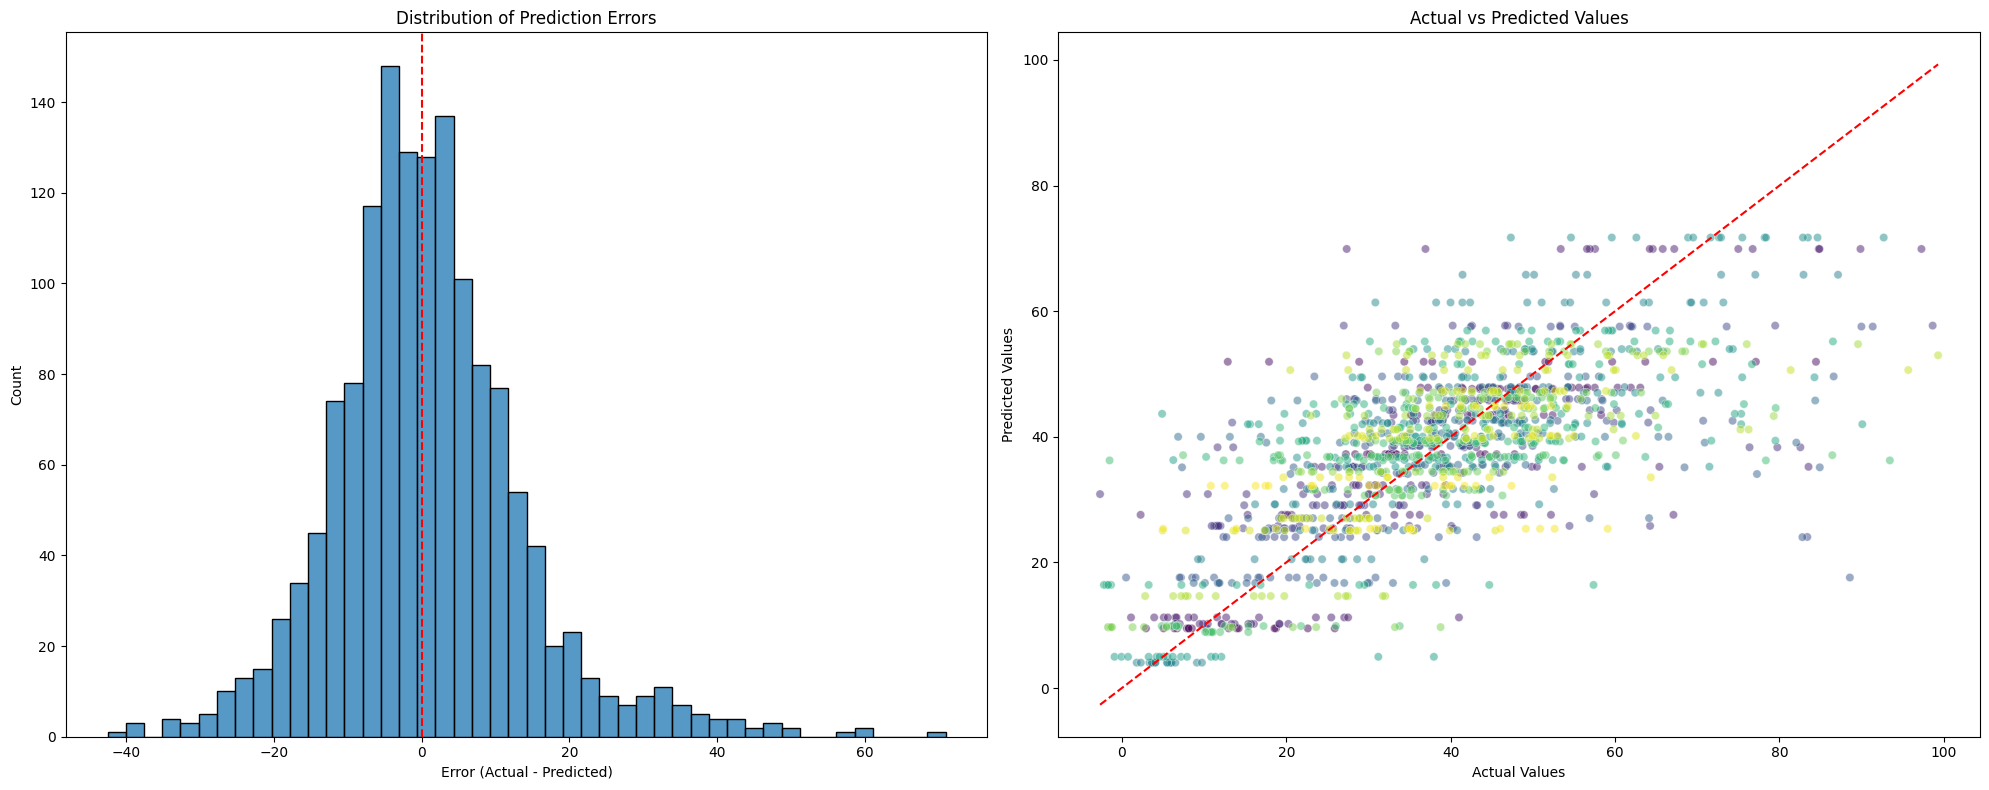

In [33]:
target = 'target_wbw_gap_detrended'

train_data_clean = train_data[[target, 'PID']].dropna()
test_data_clean = test_data[[target, 'PID']].dropna()

# Calculate median target value per subject from training data
train_medians = train_data_clean.groupby('PID')[target].median()

# Initialize predictions array
predictions = np.zeros(len(test_data_clean))

# Make predictions using each subject's median
for pid in test_data_clean['PID'].unique():
    # Get subject's data indices
    mask = test_data_clean['PID'] == pid
    
    # Use subject's training median if available, otherwise use overall median
    if pid in train_medians.index:
        subject_median = train_medians[pid]
    else:
        subject_median = train_data_clean[target].median()
        
    # Fill predictions for this subject
    predictions[mask] = subject_median

# Calculate metrics
mae = mean_absolute_error(test_data_clean[target], predictions)
rmse = np.sqrt(mean_squared_error(test_data_clean[target], predictions))
r2 = r2_score(test_data_clean[target], predictions)

# Print metrics
print(f"Baseline Model Performance Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Print data sizes
print(f"\nData sizes:")
print(f"Training samples: {len(train_data_clean)}")
print(f"Test samples: {len(test_data_clean)}")
print(f"Number of subjects in training: {len(train_data_clean['PID'].unique())}")
print(f"Number of subjects in test: {len(test_data_clean['PID'].unique())}")

# Plot diagnostics
plot_model_diagnostics(test_data_clean[target], predictions, test_data_clean)


## Pipeline Functions

In [28]:
def preprocess_data(
    train_data: pd.DataFrame,
    test_data: pd.DataFrame,
    target: str,
    features: List[str]
) -> Dict:
    """
    Perform all preprocessing steps for a given target and feature set.
    """
    # Drop rows missing target values
    train_clean = train_data.dropna(subset=[target])
    test_clean = test_data.dropna(subset=[target])
    
    # Define valid subjects as all unique PIDs in the training data
    valid_subjects = train_clean['PID'].unique().tolist()
    
    # Return processed data
    return {
        "train_data": train_clean,
        "test_data": test_clean,
        "target": target,
        "features": features,
        "valid_subjects": valid_subjects
    }

In [29]:
def create_expanding_window_splits(data, initial_val_size=10, window_size=2):
    """
    Create expanding window splits within each subject
    """
    splits = []
    
    for _ in range(5):  # 5 splits as specified
        train_indices = []
        val_indices = []
        
        for pid in data['PID'].unique():
            # Get subject's data indices
            subject_data = data[data['PID'] == pid]
            subject_indices = subject_data.index.tolist()
            
            if len(subject_indices) < initial_val_size + window_size:
                continue
                
            # Calculate split points
            n_train = len(subject_indices) - initial_val_size
            current_split = len(splits)
            val_start = n_train + (current_split * window_size)
            val_end = val_start + window_size
            
            # Add indices to appropriate sets
            train_indices.extend(subject_indices[:val_start])
            val_indices.extend(subject_indices[val_start:val_end])
        
        splits.append((train_indices, val_indices))
    
    return splits

In [30]:
def normalize_features_by_pid(
    train_data: pd.DataFrame, 
    val_data: pd.DataFrame, 
    features: List[str]
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Normalize features within each subject using training data statistics.
    """
    train_norm = train_data.copy()
    val_norm = val_data.copy()
    
    for pid in train_data['PID'].unique():
        train_mask = train_data['PID'] == pid
        val_mask = val_data['PID'] == pid
        
        for feature in features:
            # Get training statistics
            train_mean = train_data.loc[train_mask, feature].mean()
            train_std = train_data.loc[train_mask, feature].std()
            
            # Apply normalization
            if not pd.isna(train_mean) and not pd.isna(train_std) and train_std > 0:
                train_norm.loc[train_mask, feature] = (train_data.loc[train_mask, feature] - train_mean) / train_std
                
                if val_mask.any():
                    val_norm.loc[val_mask, feature] = (val_data.loc[val_mask, feature] - train_mean) / train_std
    
    return train_norm, val_norm

def impute_time_series_data(train_data, test_data, predictors, subject_col='PID', day_col='day', max_gap=7):
    """
    Impute missing values in time series data using within-subject forward/backward fill
    and mean imputation, while respecting time gaps.
    """
    # Create explicit copies at the start
    train_imputed = train_data.copy()
    test_imputed = test_data.copy()
    
    # Calculate global means from training data for each predictor
    train_global_means = train_data[predictors].mean()
    
    # Process each subject separately
    for pid in train_data[subject_col].unique():
        # Get subject data masks
        train_mask = train_data[subject_col] == pid
        test_mask = test_data[subject_col] == pid
        
        # Create complete copies of subject data
        train_subject = train_data[train_mask].copy()
        test_subject = test_data[test_mask].copy() if test_mask.any() else None
        
        # Sort by day
        train_subject = train_subject.sort_values(day_col)
        if test_subject is not None:
            test_subject = test_subject.sort_values(day_col)
        
        # Process each predictor
        for predictor in predictors:
            # Create a copy of the series to modify
            series = train_subject[predictor].copy()
            
            # Forward fill within max_gap
            for idx in range(len(series)):
                if pd.isna(series.iloc[idx]):
                    for look_back in range(idx-1, max(-1, idx-max_gap-1), -1):
                        if look_back >= 0 and not pd.isna(series.iloc[look_back]):
                            days_gap = train_subject[day_col].iloc[idx] - train_subject[day_col].iloc[look_back]
                            if days_gap <= max_gap:
                                series.iloc[idx] = series.iloc[look_back]
                            break
            
            # Backward fill within max_gap
            for idx in range(len(series)-1, -1, -1):
                if pd.isna(series.iloc[idx]):
                    for look_forward in range(idx+1, min(len(series), idx+max_gap+1)):
                        if not pd.isna(series.iloc[look_forward]):
                            days_gap = train_subject[day_col].iloc[look_forward] - train_subject[day_col].iloc[idx]
                            if days_gap <= max_gap:
                                series.iloc[idx] = series.iloc[look_forward]
                            break
            
            # Fill remaining missing values with subject mean or global mean
            subject_mean = series.mean()
            if pd.isna(subject_mean):
                subject_mean = train_global_means[predictor]
            series = series.fillna(subject_mean)
            
            # Update the data using loc
            train_imputed.loc[train_mask, predictor] = series.values
            
            # Test data imputation
            if test_subject is not None:
                test_series = test_subject[predictor].copy()
                
                # Forward fill from training data if within max_gap
                last_train_day = train_subject[day_col].iloc[-1]
                last_train_value = series.iloc[-1]
                
                for idx in range(len(test_series)):
                    if pd.isna(test_series.iloc[idx]):
                        days_gap = test_subject[day_col].iloc[idx] - last_train_day
                        if days_gap <= max_gap:
                            test_series.iloc[idx] = last_train_value
                
                # Forward and backward fill within test data
                test_series = test_series.ffill(limit=max_gap)
                test_series = test_series.bfill(limit=max_gap)
                
                # Fill remaining missing values with subject mean
                test_series = test_series.fillna(subject_mean)
                
                # Update the test data using loc
                test_imputed.loc[test_mask, predictor] = test_series.values
    
    return train_imputed, test_imputed

In [31]:
def add_subject_statistics(
    train_data: pd.DataFrame, 
    val_data: pd.DataFrame, 
    target: str
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Add subject-level statistics (median and std) as features.
    """
    train_with_stats = train_data.copy()
    val_with_stats = val_data.copy()
    
    # Calculate statistics from training data
    train_medians = train_data.groupby('PID')[target].median()
    train_stds = train_data.groupby('PID')[target].std()
    
    # Add to training data
    train_with_stats['subject_median'] = train_with_stats['PID'].map(train_medians)
    train_with_stats['subject_std'] = train_with_stats['PID'].map(train_stds)
    
    # Add to validation data
    val_with_stats['subject_median'] = val_with_stats['PID'].map(train_medians)
    val_with_stats['subject_std'] = val_with_stats['PID'].map(train_stds)
    
    # Handle missing values in validation set
    val_with_stats['subject_median'].fillna(train_medians.mean(), inplace=True)
    val_with_stats['subject_std'].fillna(train_stds.mean(), inplace=True)
    
    return train_with_stats, val_with_stats

In [32]:
def train_and_evaluate_model(
    model_name: str,
    processed_data: Dict,
    add_subject_target_stats: bool = True,
    optimization_metric: str = "average",
    hp_tuning_trials: int = 100
) -> Dict:
    """
    Train a specific model type and evaluate its performance.
    """
    if model_name == "xgboost":
        return train_xgboost_model(processed_data, add_subject_target_stats, optimization_metric, hp_tuning_trials)
    elif model_name == "gpboost":
        return train_gpboost_model(processed_data, add_subject_target_stats, optimization_metric, hp_tuning_trials)
    elif model_name == "deep_learning":
        return train_deep_learning_model(processed_data, add_subject_target_stats, optimization_metric, hp_tuning_trials)
    elif model_name == "llm":
        return train_llm_model(processed_data, add_subject_target_stats, optimization_metric, hp_tuning_trials)
    else:
        raise ValueError(f"Unknown model type: {model_name}")

In [33]:
def define_parameter_space(trial, model_type: str) -> dict:
    """
    Define hyperparameter search space for different model types.
    
    Args:
        trial: Optuna trial object for suggesting parameter values
        model_type: The type of model ('xgboost', 'gpboost', 'deep_learning', 'llm')
        
    Returns:
        Dictionary containing parameter ranges for the specified model type
    """
    if model_type == "xgboost":
        params = {
            # Core parameters
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            
            # Regularization parameters
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            
            # Fixed parameters for consistent training
            'random_state': 42,
            'n_jobs': -1,  # use all cores
            'early_stopping_rounds': 20
    }
    elif model_type == "gpboost":
        params = {
            # Core parameters
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
 
            # Regularization parameters
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            
            # Fixed parameters
            'random_state': 42,
            'objective': 'regression'
        }
    elif model_type == "deep_learning":
        params = {
            'hidden_dim': trial.suggest_int('hidden_dim', 16, 256, log=True),
            'num_layers': trial.suggest_int('num_layers', 1, 4),
            'dropout': trial.suggest_float('dropout', 0.0, 0.5),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
            'batch_size': trial.suggest_int('batch_size', 8, 64, log=True),
            
            # Fixed parameters
            'random_state': 42
        }
    elif model_type == "llm":
        params = {
            'd_model': trial.suggest_int('d_model', 64, 256, log=True),
            'nhead': trial.suggest_int('nhead', 1, 8),
            'num_layers': trial.suggest_int('num_layers', 1, 4),
            'dim_feedforward': trial.suggest_int('dim_feedforward', 128, 512, log=True),
            'dropout': trial.suggest_float('dropout', 0.0, 0.5),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True),
            
            # Fixed parameters
            'random_state': 42
        }
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    return params

def train_and_evaluate_on_split(
    model_type: str,
    params: dict,
    train_data: pd.DataFrame,
    val_data: pd.DataFrame,
    target: str,
    features: List[str],
    optimization_metric: str
) -> float:
    """
    Train a model with given parameters and evaluate on validation data.
    
    Args:
        model_type: Type of model to train
        params: Model hyperparameters
        train_data: Training data
        val_data: Validation data
        target: Target variable name
        features: List of feature names
        optimization_metric: Metric to return ('rmse', 'mae', or 'average')
        
    Returns:
        Specified metric value (lower is better)
    """
    # Train model based on type
    if model_type == "xgboost":
        model = xgb.XGBRegressor(**params)
        model.fit(
            train_data[features],
            train_data[target],
            eval_set=[(val_data[features], val_data[target])],
            verbose=False
            )
        y_pred = model.predict(val_data[features])
    
    elif model_type == "gpboost":
        # Separate GP parameters from tree parameters
        gp_params = {
            'optimizer_cov': params.get('optimizer_cov', 'lbfgs'),
            'lr_cov': params.get('lr_cov', 0.1),
            'std_dev': params.get('std_dev', True),
            'trace': params.get('trace', False),
            'use_nesterov_acc': params.get('use_nesterov_acc', True),
            'init_cov_pars': params.get('init_cov_pars', None)
        }
        
        # Add intercept column (a column of 1's) to the feature matrices
        X_train_with_intercept = train_data[features].copy()
        X_val_with_intercept = val_data[features].copy()
        X_train_with_intercept['intercept'] = 1.0
        X_val_with_intercept['intercept'] = 1.0
        
        # Get target variable
        y_train = train_data[target]
        
        # Get PID values for grouping
        group_train = train_data['PID'].values
        group_val = val_data['PID'].values
        
        # Get a mapping from PID to a numeric index
        unique_pids = np.unique(group_train)
        pid_to_idx = {pid: idx for idx, pid in enumerate(unique_pids)}
        group_train_idx = np.array([pid_to_idx[pid] for pid in group_train])
        group_val_idx = np.array([pid_to_idx[pid] if pid in pid_to_idx else -1 for pid in group_val])
        
        # Handle any validation subjects not in training data
        val_has_unknown_subjects = np.any(group_val_idx == -1)
        if val_has_unknown_subjects:
            # Assign new indices to unknown subjects
            max_idx = max(pid_to_idx.values())
            for i, idx in enumerate(group_val_idx):
                if idx == -1:
                    pid = group_val[i]
                    max_idx += 1
                    pid_to_idx[pid] = max_idx
                    group_val_idx[i] = max_idx
        
        # For random slopes, convert to numpy arrays
        X_train_np = X_train_with_intercept.values
        X_val_np = X_val_with_intercept.values
        
        # Create indices for random coefficient effects
        # Values should be 1 (not 0) to indicate they belong to the first random effect group
        ind_effect_group_rand_coef = np.ones(X_train_np.shape[1], dtype=int)
        
        # Initialize GPModel with random intercepts and random slopes
        gp_model = gpb.GPModel(
            group_data=group_train_idx,                # Use PID indices for random intercepts
            group_rand_coef_data=X_train_np,           # For random slopes
            ind_effect_group_rand_coef=ind_effect_group_rand_coef,  # Connect random slopes to groups
            likelihood="gaussian"                      # For continuous target
        )
        
        # # Set prediction data for validation set - THIS IS THE FIX
        # gp_model.set_prediction_data(
        #     group_data_pred=group_val_idx,
        #     group_rand_coef_data_pred=X_val_np
        # )
        
        # Fit the GP model with GP parameters only
        gp_model.fit(y=y_train.values, params=gp_params)
                            
        # # Create GPBoostRegressor with tree parameters
        # gbt_model = gpb.GPBoostRegressor(**params)
        
        # # Train the combined model
        # gbt_model.fit(X_train_with_intercept, y_train, 
        #              gp_model=gp_model,
        #              eval_set=[(X_val_with_intercept, val_data[target])],
        #              verbose=False)
        
        # Make predictions on validation set
        # y_pred = gbt_model.predict(X_val_with_intercept)
        predictions = gp_model.predict(
            group_data_pred=group_val_idx,
            group_rand_coef_data_pred=X_val_np,
            predict_var=True                         # Include prediction variance
        )
        y_pred = predictions['mu']
    
    elif model_type == "deep_learning":
        # Placeholder for deep learning model training
        # In a real implementation, this would create and train a PyTorch model
        y_pred = val_data[target].mean() * np.ones(len(val_data))
    
    elif model_type == "llm":
        # Placeholder for LLM model training
        # In a real implementation, this would use a transformer model
        y_pred = val_data[target].mean() * np.ones(len(val_data))
    
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Calculate metrics
    y_true = val_data[target].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Return specified metric
    if optimization_metric == "rmse":
        return rmse
    elif optimization_metric == "mae":
        return mae
    else:  # "average"
        return (rmse + mae) / 2

def tune_model_hyperparameters(
    model_type: str,
    train_data: pd.DataFrame,
    target: str,
    features: List[str],
    add_subject_target_stats: bool,
    optimization_metric: str,
    hp_tuning_trials: int
) -> Dict:
    """
    Tune hyperparameters for a specific model type.
    """
    # Create CV splits using expanding window approach
    cv_splits = create_expanding_window_splits(train_data)
    
    # Create Optuna study
    study = optuna.create_study(direction="minimize")
    
    # Define objective function
    def objective(trial):
        # Get parameter suggestions for this trial
        params = define_parameter_space(trial, model_type)
        
        # Track performance across CV splits
        split_metrics = []
        
        for train_idx, val_idx in cv_splits:
            # Get split data
            split_train = train_data.loc[train_idx]
            split_val = train_data.loc[val_idx]
            
            # Normalize features within PID
            split_train_norm, split_val_norm = normalize_features_by_pid(
                split_train, split_val, features
            )
            
            # Impute missing values
            split_train_norm, split_val_norm = impute_time_series_data(
                split_train_norm, split_val_norm, features
            )
            
            # Add subject target statistics if requested
            if add_subject_target_stats:
                split_train_norm, split_val_norm = add_subject_statistics(
                    split_train_norm, split_val_norm, target
                )
                
            # Train and evaluate model
            metric = train_and_evaluate_on_split(
                model_type, params, split_train_norm, split_val_norm, 
                target, features, optimization_metric
            )
            
            split_metrics.append(metric)
        
        # Return average metric across splits
        return np.mean(split_metrics)
    
    # Run optimization
    study.optimize(objective,
                   n_trials=hp_tuning_trials,
                   show_progress_bar=True
                   )
    
    return study.best_params

In [34]:
def prepare_sequence_data(
    train_data: pd.DataFrame,
    test_data: pd.DataFrame,
    features: List[str],
    target: str,
    subject_col: str,
    time_col: str,
    max_seq_len: int = 100
) -> Dict:
    """
    Prepare sequential data for LSTM/RNN models.
    
    Args:
        train_data: Training dataframe
        test_data: Test dataframe
        features: Feature columns
        target: Target column
        subject_col: Subject ID column name
        time_col: Time/sequence column name
        max_seq_len: Maximum sequence length
        
    Returns:
        Dictionary containing:
            - X_train_seq: List of training feature sequences
            - y_train_seq: List of training target sequences
            - X_test_seq: List of test feature sequences
            - y_test_seq: List of test target sequences
            - train_lengths: List of actual sequence lengths for training
            - test_lengths: List of actual sequence lengths for testing
    """
    # Prepare sequences by subject
    X_train_seq, y_train_seq, train_lengths = [], [], []
    X_test_seq, y_test_seq, test_lengths = [], [], []
    
    # Process training data
    for subject in train_data[subject_col].unique():
        # Get subject data and sort by time
        subject_data = train_data[train_data[subject_col] == subject].sort_values(time_col)
        
        # Extract features and target
        X_seq = subject_data[features].values
        y_seq = subject_data[target].values
        
        # Pad or truncate sequence
        seq_len = min(len(X_seq), max_seq_len)
        padded_X = np.zeros((max_seq_len, len(features)))
        padded_y = np.zeros(max_seq_len)
        
        padded_X[:seq_len] = X_seq[:seq_len]
        padded_y[:seq_len] = y_seq[:seq_len]
        
        # Store sequence
        X_train_seq.append(padded_X)
        y_train_seq.append(padded_y)
        train_lengths.append(seq_len)
    
    # Process test data
    for subject in test_data[subject_col].unique():
        # Get subject data and sort by time
        subject_data = test_data[test_data[subject_col] == subject].sort_values(time_col)
        
        # Extract features and target
        X_seq = subject_data[features].values
        y_seq = subject_data[target].values
        
        # Pad or truncate sequence
        seq_len = min(len(X_seq), max_seq_len)
        padded_X = np.zeros((max_seq_len, len(features)))
        padded_y = np.zeros(max_seq_len)
        
        padded_X[:seq_len] = X_seq[:seq_len]
        padded_y[:seq_len] = y_seq[:seq_len]
        
        # Store sequence
        X_test_seq.append(padded_X)
        y_test_seq.append(padded_y)
        test_lengths.append(seq_len)
    
    return {
        "X_train_seq": np.array(X_train_seq),
        "y_train_seq": np.array(y_train_seq),
        "X_test_seq": np.array(X_test_seq),
        "y_test_seq": np.array(y_test_seq),
        "train_lengths": np.array(train_lengths),
        "test_lengths": np.array(test_lengths)
    }

In [35]:
def calculate_all_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    test_data: pd.DataFrame,
    train_data: pd.DataFrame,
    target: str
) -> Dict:
    """
    Calculate all evaluation metrics.
    """
    print("Calculating all metrics")
    
    # Basic regression metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    avg_error = (mae + rmse) / 2
    r2 = r2_score(y_true, y_pred)
    
    # Calculate subject median from training data
    train_medians = train_data.groupby('PID')[target].median()
    
    # Calculate median accuracy
    median_accuracy, median_ci = calculate_median_accuracy(
        y_true, y_pred, test_data['PID'], train_medians
    )
    
    # Calculate direction accuracy
    direction_accuracy, direction_ci = calculate_direction_accuracy(
        y_true, y_pred, test_data['PID'], test_data['day']
    )
    
    # Return all metrics
    return {
        'mae': mae,
        'rmse': rmse,
        'avg_error': avg_error,
        'r2': r2,
        'median_accuracy': median_accuracy,
        'median_accuracy_ci': median_ci,
        'direction_accuracy': direction_accuracy,
        'direction_accuracy_ci': direction_ci
    }

def calculate_median_accuracy(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    subject_ids: np.ndarray,
    subject_medians: pd.Series,
    n_bootstrap: int = 1000
) -> Tuple[float, Tuple[float, float]]:
    """
    Calculate accuracy of predicting whether values are above/below subject median.
    """
    # Convert pandas Series to numpy arrays if needed
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    if isinstance(subject_ids, pd.Series):
        subject_ids = subject_ids.values
    
    correct = 0
    total = 0
    
    # Calculate raw accuracy
    for pid in np.unique(subject_ids):
        mask = subject_ids == pid
        if pid in subject_medians.index:
            subject_median = subject_medians[pid]
            
            actual_above = y_true[mask] > subject_median
            pred_above = y_pred[mask] > subject_median
            
            correct += np.sum(actual_above == pred_above)
            total += np.sum(mask)
    
    accuracy = correct / total if total > 0 else 0
    
    # Bootstrap confidence interval
    bootstrap_accuracies = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(len(y_true), len(y_true), replace=True)
        bs_y_true = y_true[indices]
        bs_y_pred = y_pred[indices]
        bs_subjects = subject_ids[indices]
        
        bs_correct = 0
        bs_total = 0
        
        for pid in np.unique(bs_subjects):
            mask = bs_subjects == pid
            if pid in subject_medians.index:
                subject_median = subject_medians[pid]
                
                actual_above = bs_y_true[mask] > subject_median
                pred_above = bs_y_pred[mask] > subject_median
                
                bs_correct += np.sum(actual_above == pred_above)
                bs_total += np.sum(mask)
        
        if bs_total > 0:
            bootstrap_accuracies.append(bs_correct / bs_total)
    
    # Calculate 95% confidence interval
    ci_lower, ci_upper = np.percentile(bootstrap_accuracies, [2.5, 97.5])
    
    return accuracy, (ci_lower, ci_upper)

def calculate_direction_accuracy(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    subject_ids: np.ndarray,
    days: np.ndarray,
    n_bootstrap: int = 1000
) -> Tuple[float, Tuple[float, float]]:
    """
    Calculate accuracy of predicting direction of change from previous day.
    """
    # Convert pandas Series to numpy arrays if needed
    if isinstance(y_true, pd.Series):
        y_true = y_true.values
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.values
    if isinstance(subject_ids, pd.Series):
        subject_ids = subject_ids.values
    if isinstance(days, pd.Series):
        days = days.values
        
    # Create DataFrame for easier handling
    data = pd.DataFrame({
        'y_true': y_true,
        'y_pred': y_pred,
        'subject': subject_ids,
        'day': days
    })
    
    # Sort by subject and day
    data = data.sort_values(['subject', 'day'])
    
    # Initialize counters
    correct = 0
    total = 0
    
    # Process each subject
    for pid in data['subject'].unique():
        subject_data = data[data['subject'] == pid].copy()
        
        # Calculate day-to-day changes
        subject_data['true_diff'] = subject_data['y_true'].diff()
        subject_data['pred_diff'] = subject_data['y_pred'].diff()
        
        # Skip first day (no diff) and check only consecutive days
        for i in range(1, len(subject_data)):
            if subject_data.iloc[i]['day'] - subject_data.iloc[i-1]['day'] == 1:
                true_direction = np.sign(subject_data.iloc[i]['true_diff'])
                pred_direction = np.sign(subject_data.iloc[i]['pred_diff'])
                
                if true_direction == pred_direction:
                    correct += 1
                total += 1
    
    accuracy = correct / total if total > 0 else 0
    
    # Bootstrap confidence interval
    bootstrap_accuracies = []
    for _ in range(n_bootstrap):
        bs_correct = 0
        bs_total = 0
        
        # Resample subjects with replacement
        bs_subjects = np.random.choice(data['subject'].unique(), len(data['subject'].unique()), replace=True)
        
        for pid in bs_subjects:
            subject_data = data[data['subject'] == pid].copy()
            
            # Calculate day-to-day changes
            subject_data['true_diff'] = subject_data['y_true'].diff()
            subject_data['pred_diff'] = subject_data['y_pred'].diff()
            
            # Skip first day (no diff) and check only consecutive days
            for i in range(1, len(subject_data)):
                if subject_data.iloc[i]['day'] - subject_data.iloc[i-1]['day'] == 1:
                    true_direction = np.sign(subject_data.iloc[i]['true_diff'])
                    pred_direction = np.sign(subject_data.iloc[i]['pred_diff'])
                    
                    if true_direction == pred_direction:
                        bs_correct += 1
                    bs_total += 1
        
        if bs_total > 0:
            bootstrap_accuracies.append(bs_correct / bs_total)
    
    # Calculate 95% confidence interval
    ci_lower, ci_upper = np.percentile(bootstrap_accuracies, [2.5, 97.5])
    
    return accuracy, (ci_lower, ci_upper)

In [36]:
def run_analysis_pipeline(
    targets: List[str],
    feature_sets: Dict[str, List[str]],
    models_to_run: List[str] = ["xgboost", "gpboost", "deep_learning", "llm"],
    add_subject_target_stats: bool = True,
    optimization_metric: str = "average",
    hp_tuning_trials: int = 100
):
    """
    Main pipeline function that coordinates the entire analysis.
    """
    # Suppress verbose Optuna logging
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    # Try to load existing results if available
    results_path = 'intermediate_results.pkl'
    if os.path.exists(results_path):
        try:
            with open(results_path, 'rb') as f:
                results = pickle.load(f)
            print(f"Loaded existing results from {results_path}")
        except Exception as e:
            print(f"Could not load existing results: {e}")
            results = {}
    else:
        results = {}
    
    for target in targets:
        if target not in results:
            results[target] = {}
        
        for feature_set_name, features in feature_sets.items():
            print(f"\nProcessing target....{target}\nFeature set..........{feature_set_name}")
            
            if feature_set_name not in results[target]:
                results[target][feature_set_name] = {}
            
            # Remove duplicates while preserving order for combined feature sets
            features = list(dict.fromkeys(features))
            
            # Preprocess data once per target/feature combination
            processed_data = preprocess_data(train_data, test_data, target, features)
            
            for model_name in models_to_run:
                # Skip if this model has already been processed
                if model_name in results[target][feature_set_name]:
                    print(f"Skipping already processed model: {model_name}")
                    continue
                    
                print(f"Training model.......{model_name}")
                
                # Train model, make predictions, evaluate
                try:
                    model_results = train_and_evaluate_model(
                        model_name=model_name,
                        processed_data=processed_data,
                        add_subject_target_stats=add_subject_target_stats,
                        optimization_metric=optimization_metric,
                        hp_tuning_trials=hp_tuning_trials
                    )
                    
                    results[target][feature_set_name][model_name] = model_results
                    
                    # Save intermediate results after each model completes
                    with open(results_path, 'wb') as f:
                        pickle.dump(results, f)
                    print(f"Saved results to {results_path}")
                    
                except Exception as e:
                    print(f"Error training {model_name}: {e}")
    
    return results

## Model Implementations

### XGBoost


In [37]:
def train_xgboost_model(
    processed_data: Dict[str, Any], 
    add_subject_target_stats: bool, 
    optimization_metric: str, 
    hp_tuning_trials: int
) -> Dict[str, Any]:
    """
    Train and evaluate an XGBoost regression model on the processed data.
    
    This function performs hyperparameter tuning, data preprocessing (normalization 
    and imputation), trains an XGBoost model, and evaluates its performance on test data.
    
    Parameters
    ----------
    processed_data : Dict[str, Any]
        Dictionary containing processed data with the following keys:
        - "train_data": pd.DataFrame with training data
        - "test_data": pd.DataFrame with test data
        - "target": str, name of target variable
        - "features": List[str], feature column names
        - "valid_subjects": List[str], list of valid subject IDs
    add_subject_target_stats : bool
        Whether to add subject-level statistics (median, std) as features
    optimization_metric : str
        Metric to optimize during hyperparameter tuning ('rmse', 'mae', or 'average')
    hp_tuning_trials : int
        Number of trials for hyperparameter optimization
        
    Returns
    -------
    Dict[str, Any]
        Dictionary containing model results with the following keys:
        - 'model': trained XGBRegressor model
        - 'best_params': dict of best hyperparameters
        - 'predictions': np.ndarray of model predictions on test data
        - 'actual': np.ndarray of actual target values
        - 'metrics': dict of performance metrics
        - 'feature_importance': pd.DataFrame of feature importance scores
    """
    # Tune hyperparameters
    best_params = tune_model_hyperparameters(
        "xgboost", 
        processed_data["train_data"],
        processed_data["target"],
        processed_data["features"],
        add_subject_target_stats,
        optimization_metric,
        hp_tuning_trials
    )
    
    # Normalize and impute full training and test data
    train_norm, test_norm = normalize_features_by_pid(
        processed_data["train_data"],
        processed_data["test_data"],
        processed_data["features"]
    )
    
    train_imputed, test_imputed = impute_time_series_data(
        train_norm, 
        test_norm,
        processed_data["features"]
    )
    
    # Add subject statistics if requested
    if add_subject_target_stats:
        train_final, test_final = add_subject_statistics(
            train_imputed, 
            test_imputed,
            processed_data["target"]
        )
    else:
        train_final, test_final = train_imputed, test_imputed
    
    # Prepare feature columns
    feature_cols = processed_data["features"].copy()
    if add_subject_target_stats:
        feature_cols.extend(['subject_median', 'subject_std'])
    
    # Train final model
    model = xgb.XGBRegressor(**best_params)
    model.fit(
        train_final[feature_cols],
        train_final[processed_data["target"]]
    )
    
    # Make predictions
    y_pred = model.predict(test_final[feature_cols])
    y_true = test_final[processed_data["target"]]
    
    # Calculate metrics
    metrics = calculate_all_metrics(
        y_true,
        y_pred,
        test_final,
        train_final,
        processed_data["target"]
    )
    
    # Calculate feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Return results
    return {
        'model': model,
        'best_params': best_params,
        'predictions': y_pred,
        'actual': y_true,
        'metrics': metrics,
        'feature_importance': feature_importance
    }

### GPBoost

In [38]:
features = task_1000_z2
target = 'target_wbw_gap_detrended'
processed_data = preprocess_data(train_data, test_data, target, features)
add_subject_target_stats = False
optimization_metric = 'average'
# hp_tuning_trials = 10

train_gpboost_model_alt(processed_data, 
                        add_subject_target_stats=False,
                        optimization_metric = optimization_metric,
                        hp_tuning_trials = 10
                        )

NameError: name 'task_1000_z2' is not defined

In [74]:
def normalize_features_for_split(train_data, val_data, predictors, subject_col='PID'):
    """
    Normalize features within subject using only training data statistics
    """
    # Create explicit copies to preserve all columns
    train_normalized = train_data.copy()
    val_normalized = val_data.copy()
    norm_params = {}
    
    # Only normalize predictor columns
    for pid in train_data[subject_col].unique():
        train_mask = train_data[subject_col] == pid
        val_mask = val_data[subject_col] == pid
        
        for predictor in predictors:
            # Calculate parameters from training data only
            mean = train_data.loc[train_mask, predictor].mean()
            std = train_data.loc[train_mask, predictor].std()
            if std == 0:
                std = 1
                
            # Store parameters
            if pid not in norm_params:
                norm_params[pid] = {}
            norm_params[pid][predictor] = {'mean': mean, 'std': std}
            
            # Apply normalization only to predictor columns
            train_normalized.loc[train_mask, predictor] = (train_data.loc[train_mask, predictor] - mean) / std
            if val_mask.any():
                val_normalized.loc[val_mask, predictor] = (val_data.loc[val_mask, predictor] - mean) / std
    
    return train_normalized, val_normalized, norm_params

In [86]:
# GPBoost 03minihigh

# ------------------------------
# Define the Optuna Objective Function
# ------------------------------
def objective(trial):
    # Suggest hyperparameters for boosting
    params = {
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int("max_depth", 1, 6),
        'num_leaves': trial.suggest_int("num_leaves", 3, 100),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 3.0, log=True),
        'num_boost_round': trial.suggest_int("num_boost_round", 50, 300)
    }

    # Store RMSE scores from each fold
    fold_scores = []
    
    # This function returns a list of (train_indices, valid_indices) tuples.
    splits = create_expanding_window_splits(train_data_clean)

    # Iterate over the pre-computed expanding window splits
    for train_idx, val_idx in splits:
        try:
            # Get split data
            split_train = train_data_clean.loc[train_idx]
            split_val = train_data_clean.loc[val_idx]
            
            # Normalize features
            split_train_norm, split_val_norm, _ = normalize_features_for_split(
                split_train, 
                split_val, 
                features,
                subject_col='PID'
            )
            
            # Initialize feature columns list
            feature_cols = features.copy()
            
            # Prepare training data
            X_train_split = split_train_norm[feature_cols]
            y_train_split = split_train_norm[target]
            group_train = split_train_norm['PID'].values
            
            # Prepare validation data
            X_val_split = split_val_norm[feature_cols]
            y_val_split = split_val_norm[target]
            
            # Get PID values for grouping
            group_train = split_train_norm['PID'].values
            group_test = split_val_norm['PID'].values
            
            # Get a mapping from PID to a numeric index (needed for GPBoost)
            unique_pids = np.unique(group_train)
            pid_to_idx = {pid: idx for idx, pid in enumerate(unique_pids)}
            group_train_idx = np.array([pid_to_idx[pid] for pid in group_train])
            group_test_idx = np.array([pid_to_idx[pid] if pid in pid_to_idx else -1 for pid in group_test])

            # Handle any test subjects not in training data
            test_has_unknown_subjects = np.any(group_test_idx == -1)
            if test_has_unknown_subjects:
                # Assign new indices to unknown subjects
                max_idx = max(pid_to_idx.values())
                for i, idx in enumerate(group_test_idx):
                    if idx == -1:
                        pid = group_test[i]
                        max_idx += 1
                        pid_to_idx[pid] = max_idx
                        group_test_idx[i] = max_idx

            # For random slopes, convert to numpy arrays
            X_train_np = X_train_split.values
            X_test_np = X_val_split.values

            # Create indices for random coefficient effects
            ind_effect_group_rand_coef = np.ones(X_train_np.shape[1], dtype=int)

            # Initialize GPModel with random intercepts and random slopes
            gp_model = gpb.GPModel(
                group_data=group_train_idx,
                group_rand_coef_data=X_train_np,
                ind_effect_group_rand_coef=ind_effect_group_rand_coef,
                likelihood="gaussian"
            )
            
            # Set optimization parameters
            gp_params = {
                "optimizer_cov": "lbfgs",
                "lr_cov": 0.1,
                "std_dev": True,
                "trace": False,  # Set to False to reduce output
                "use_nesterov_acc": True,
                "init_cov_pars": None
            }
            
            # Fit the GP model
            gp_model.fit(y=y_train_split.values, params=gp_params)

            # Initialize the GPBoostRegressor with the GPModel for random effects
            model = gpb.GPBoostRegressor(**params)
            
            # Fit the model using early stopping on the validation set
            model.fit(
                X_train_split, y_train_split,
                gp_model=gp_model,  # Pass the GP model here
                eval_set=[(X_val_split, y_val_split)],
                early_stopping_rounds=20,
                verbose=False
            )
            
            # Predict on the validation set and compute RMSE
            y_pred = model.predict(X_val_split)
            rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
            fold_scores.append(rmse)
            
            # Clean up to avoid memory issues
            del gp_model
            del model
            
        except Exception as e:
            print(f"Error in fold: {e}")
            # If a fold fails, assign a high error score
            fold_scores.append(float('inf'))
    
    # Return the average RMSE across folds as the objective to minimize
    # If all folds failed, return a high value
    if all(score == float('inf') for score in fold_scores):
        return float('inf')
    
    # Filter out any failed folds
    valid_scores = [score for score in fold_scores if score != float('inf')]
    avg_rmse = np.mean(valid_scores) if valid_scores else float('inf')
    return avg_rmse

In [ ]:
# ------------------------------
# Main Script
# ------------------------------
if __name__ == '__main__':
    # ------------------------------
    # Load and Prepare Data
    # ------------------------------
    # Replace this section with your actual data loading/cleaning steps.
    # Assume df is your cleaned training DataFrame with:
    # - 'PID' as the subject grouping column
    # - 'target' as the target variable
    # - all other columns as features.
    features = task_1000_z2
    target = 'target_wbw_gap_detrended'
    
    # Subset features and target
    train_data_clean = train_data_clean[features + ['PID', 'day', target]]
    test_data_clean = test_data_clean[features + ['PID', 'day', target]]
    
    train_data_clean, test_data_clean = impute_time_series_data(
        train_data_clean,
        test_data_clean,
        features,
        max_gap=7 
    )
    
    # Extra check to ensure no NaN, inf, or extreme values in target
    train_data_clean = train_data_clean[~train_data_clean[target].isna()]
    train_data_clean = train_data_clean[~np.isinf(train_data_clean[target])]
    test_data_clean = test_data_clean[~test_data_clean[target].isna()]
    test_data_clean = test_data_clean[~np.isinf(test_data_clean[target])]
    
    # Check for and remove extreme values if needed
    max_val = 1e9  # Adjust as needed
    train_data_clean = train_data_clean[np.abs(train_data_clean[target]) < max_val]
    test_data_clean = test_data_clean[np.abs(test_data_clean[target]) < max_val]
    
    # ------------------------------
    # Hyperparameter Tuning with Optuna
    # ------------------------------
    study = optuna.create_study(direction="minimize")
    
    # Run optimization with progress bar
    study.optimize(
        objective,
        n_trials=50,
        show_progress_bar = True,
        catch=(Exception,)  # Catch all exceptions to prevent study from failing
    )

    print("Best trial:")
    print("  RMSE: {}".format(study.best_trial.value))
    print("  Best hyperparameters: {}".format(study.best_trial.params))
    
    # ------------------------------
    # Train Final Model on the Entire Data Using Best Hyperparameters
    # ------------------------------
    feature_columns = [col for col in train_data_clean.columns if col not in ['PID', 'target']]
    X_full = train_data_clean[feature_columns].values
    y_full = train_data_clean[target].values
    group_full = train_data_clean['PID'].values

    # Create the GPModel for the full dataset
    gp_model_full = gpb.GPModel(
        group_data=group_full,
        covariate_data=X_full,
        covariate_rand_coef=True
    )
    
    final_params = {
        'objective': 'regression',
        'learning_rate': study.best_trial.params["learning_rate"],
        'max_depth': study.best_trial.params["max_depth"],
        'num_leaves': study.best_trial.params["num_leaves"],
        'min_data_in_leaf': study.best_trial.params["min_data_in_leaf"],
    }
    
    final_model = gpb.GPBoostRegressor(gp_model=gp_model_full, **final_params)
    final_model.fit(
        X_full, y_full,
        group_data=group_full,
        num_boost_round=study.best_trial.params["num_boost_round"],
        verbose_eval=True
    )
    
    # Optionally, save the final model for later use.
    final_model.save_model("final_gpboost_model.txt")
    
    print("Final model training completed.")

  0%|          | 0/50 [00:00<?, ?it/s]

[GPBoost] [Warning] There is no intercept for modeling a possibly non-zero mean of the random effects. Consider including an intercept (= a column of 1's) in the covariates 'X' 


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/gpboost/engine.py:188: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Error in fold: Prediction data for 'gp_model' has not been set. This needs to be set prior to trainig when having a validation set and 'use_gp_model_for_validation=True'. Either call 'gp_model.set_prediction_data(...)' first or use 'use_gp_model_for_validation=False'.
[GPBoost] [Warning] There is no intercept for modeling a possibly non-zero mean of the random effects. Consider including an intercept (= a column of 1's) in the covariates 'X' 


/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/gpboost/engine.py:188: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


Error in fold: Prediction data for 'gp_model' has not been set. This needs to be set prior to trainig when having a validation set and 'use_gp_model_for_validation=True'. Either call 'gp_model.set_prediction_data(...)' first or use 'use_gp_model_for_validation=False'.
[GPBoost] [Warning] There is no intercept for modeling a possibly non-zero mean of the random effects. Consider including an intercept (= a column of 1's) in the covariates 'X' 
[W 2025-03-04 23:28:26,847] Trial 0 failed with parameters: {'learning_rate': 0.020953511081601903, 'max_depth': 6, 'num_leaves': 20, 'min_data_in_leaf': 72, 'reg_alpha': 4.504548521094056e-06, 'reg_lambda': 0.4189320677971255, 'num_boost_round': 291} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_t

KeyboardInterrupt: 

In [63]:
def train_gpboost_model_alt(
    processed_data: Dict[str, Any], 
    add_subject_target_stats: bool, 
    optimization_metric: str, 
    hp_tuning_trials: int
) -> Dict[str, Any]:
    """
    Train and evaluate a GPBoost regression model on the processed data.
    
    This function performs hyperparameter tuning, data preprocessing (normalization 
    and imputation), trains a GPBoost model with random effects, and evaluates 
    its performance on test data.
    
    Parameters
    ----------
    processed_data : Dict[str, Any]
        Dictionary containing processed data with the following keys:
        - "train_data": pd.DataFrame with training data
        - "test_data": pd.DataFrame with test data
        - "target": str, name of target variable
        - "features": List[str], feature column names
        - "valid_subjects": List[str], list of valid subject IDs
    add_subject_target_stats : bool
        Whether to add subject-level statistics (median, std) as features
    optimization_metric : str
        Metric to optimize during hyperparameter tuning ('rmse', 'mae', or 'average')
    hp_tuning_trials : int
        Number of trials for hyperparameter optimization
        
    Returns
    -------
    Dict[str, Any]
        Dictionary containing model results with the following keys:
        - 'model': trained GPBoost model
        - 'best_params': dict of best hyperparameters
        - 'predictions': np.ndarray of model predictions on test data
        - 'actual': np.ndarray of actual target values
        - 'metrics': dict of performance metrics
        - 'random_effects': information about the fitted random effects
    """
    # Have not figured out how to tune hyperparameters for GPBoost yet
    # Seems like there are two parts to the model:
    # 1. The GP model
    # 2. The GBT model
    # We need to tune the hyperparameters for both parts
    # I have not figured out how to do this yet
    # For now, just use the default hyperparameters and a simple train/test split
    #########################################################
    # # Tune hyperparameters
    # best_params = tune_model_hyperparameters(
    #     "gpboost", 
    #     processed_data["train_data"],
    #     processed_data["target"],
    #     processed_data["features"],
    #     add_subject_target_stats,
    #     optimization_metric,
    #     hp_tuning_trials
    # )
    
    # Normalize and impute full training and test data
    train_norm, test_norm = normalize_features_by_pid(
        processed_data["train_data"],
        processed_data["test_data"],
        processed_data["features"]
    )
    
    train_imputed, test_imputed = impute_time_series_data(
        train_norm, 
        test_norm,
        processed_data["features"]
    )
    
    # Add subject statistics if requested
    # Note that for hierarchical model it should be calculating subject stats on its own
    add_subject_target_stats = False
    if add_subject_target_stats:
        train_final, test_final = add_subject_statistics(
            train_imputed, 
            test_imputed,
            processed_data["target"]
        )
    else:
        train_final, test_final = train_imputed, test_imputed
    
    # Prepare feature columns
    feature_cols = processed_data["features"].copy()
    if add_subject_target_stats:
        feature_cols.extend(['subject_median', 'subject_std'])
    
    # Filter features
    X_train = train_final[feature_cols]
    X_test = test_final[feature_cols]
    
    # Add intercept column (a column of 1's) to the feature matrices
    # Make sure the intercept is the FIRST column for clarity
    X_train_with_intercept = X_train.copy()
    X_test_with_intercept = X_test.copy()
    
    # Create a new DataFrame with intercept as the first column
    X_train_with_intercept = pd.DataFrame({
        'intercept': np.ones(len(X_train)),
        **X_train
    })
    
    X_test_with_intercept = pd.DataFrame({
        'intercept': np.ones(len(X_test)),
        **X_test
    })
    
    # Get target variable
    y_train = train_final[processed_data["target"]]
    y_test = test_final[processed_data["target"]]
    
    # Get PID values for grouping
    group_train = train_final['PID'].values
    group_test = test_final['PID'].values
    
    # Get a mapping from PID to a numeric index (needed for GPBoost)
    unique_pids = np.unique(group_train)
    pid_to_idx = {pid: idx for idx, pid in enumerate(unique_pids)}
    group_train_idx = np.array([pid_to_idx[pid] for pid in group_train])
    group_test_idx = np.array([pid_to_idx[pid] if pid in pid_to_idx else -1 for pid in group_test])

    # Handle any test subjects not in training data
    test_has_unknown_subjects = np.any(group_test_idx == -1)
    if test_has_unknown_subjects:
        # Assign new indices to unknown subjects
        max_idx = max(pid_to_idx.values())
        for i, idx in enumerate(group_test_idx):
            if idx == -1:
                pid = group_test[i]
                max_idx += 1
                pid_to_idx[pid] = max_idx
                group_test_idx[i] = max_idx

    # For random slopes, convert to numpy arrays
    X_train_np = X_train_with_intercept.values
    X_test_np = X_test_with_intercept.values

    # Create indices for random coefficient effects
    # Values should be 1 (not 0) to indicate they belong to the first random effect group
    # The length should match the number of columns in X_train_np
    ind_effect_group_rand_coef = np.ones(X_train_np.shape[1], dtype=int)

    # Initialize GPModel with random intercepts and random slopes
    gp_model = gpb.GPModel(
        group_data=group_train_idx,                # Use PID indices for random intercepts
        group_rand_coef_data=X_train_np,           # For random slopes
        ind_effect_group_rand_coef=ind_effect_group_rand_coef,  # Connect random slopes to groups
        likelihood="gaussian",                     # For continuous target
    )
    
    # Define parameter space for GPBoost
    params = {
        # GPBoost parameters
        'optimizer_cov': 'lbfgs',                # Optimization algorithm
        'lr_cov': 0.1,                           # Learning rate for covariance parameters
        'std_dev': True,                         # Calculate standard deviations
        'trace': False,                          # Show progress
        'use_nesterov_acc': True,                # Use Nesterov acceleration
        'init_cov_pars': None                    # Let GPBoost select initial values
        }
    
    # Since we are not tuning hyperparameters, we can just use the default parameters
    best_params = params
    
    # Fit the model
    print(f'Fitting final model...')
    gp_model.fit(y=y_train.values, params=params)
    
    # Make predictions with random effects
    predictions = gp_model.predict(
        group_data_pred=group_test_idx,
        group_rand_coef_data_pred=X_test_np,
        predict_var=True                         # Include prediction variance
    )
    
    # Extract predictions
    y_pred = predictions['mu']
    pred_var = predictions.get('var', None)
    y_true = test_final[processed_data["target"]]
    
    # Calculate metrics
    metrics = calculate_all_metrics(
        y_true,
        y_pred,
        test_final,
        train_final,
        processed_data["target"]
    )
    
    # # Calculate feature importance
    # feature_importance = pd.DataFrame({
    #     'feature': feature_cols,
    #     'importance': gp_model.feature_importances_
    # }).sort_values('importance', ascending=False)
    
    # Extract random effects information for interpretation
    random_effects_info = {
        'cov_pars': gp_model.get_cov_pars(),
        'random_effects_mean': gp_model.get_random_effects_mean(),
        'random_effects_cov': gp_model.get_random_effects_cov()
    }
    
    # Return results
    return {
        'model': gp_model,
        'best_params': best_params,
        'predictions': y_pred,
        'prediction_variance': pred_var,
        'actual': y_test.values,
        'metrics': metrics,
        'random_effects': random_effects_info,
        'feature_names': list(X_train_with_intercept.columns)
    }

In [52]:
def train_gpboost_model(
    processed_data: Dict[str, Any], 
    add_subject_target_stats: bool, 
    optimization_metric: str, 
    hp_tuning_trials: int
) -> Dict[str, Any]:
    """
    Train and evaluate a GPBoost regression model on the processed data.
    
    This function performs hyperparameter tuning, data preprocessing (normalization 
    and imputation), trains a GPBoost model with random effects, and evaluates 
    its performance on test data.
    
    Parameters
    ----------
    processed_data : Dict[str, Any]
        Dictionary containing processed data with the following keys:
        - "train_data": pd.DataFrame with training data
        - "test_data": pd.DataFrame with test data
        - "target": str, name of target variable
        - "features": List[str], feature column names
        - "valid_subjects": List[str], list of valid subject IDs
    add_subject_target_stats : bool
        Whether to add subject-level statistics (median, std) as features
    optimization_metric : str
        Metric to optimize during hyperparameter tuning ('rmse', 'mae', or 'average')
    hp_tuning_trials : int
        Number of trials for hyperparameter optimization
        
    Returns
    -------
    Dict[str, Any]
        Dictionary containing model results with the following keys:
        - 'model': trained GPBoost model
        - 'best_params': dict of best hyperparameters
        - 'predictions': np.ndarray of model predictions on test data
        - 'actual': np.ndarray of actual target values
        - 'metrics': dict of performance metrics
        - 'random_effects': information about the fitted random effects
    """
    # Have not figured out how to tune hyperparameters for GPBoost yet
    # Seems like there are two parts to the model:
    # 1. The GP model
    # 2. The GBT model
    # We need to tune the hyperparameters for both parts
    # I have not figured out how to do this yet
    # For now, just use the default hyperparameters and a simple train/test split
    #########################################################
    # # Tune hyperparameters
    # best_params = tune_model_hyperparameters(
    #     "gpboost", 
    #     processed_data["train_data"],
    #     processed_data["target"],
    #     processed_data["features"],
    #     add_subject_target_stats,
    #     optimization_metric,
    #     hp_tuning_trials
    # )
    
    # Normalize and impute full training and test data
    train_norm, test_norm = normalize_features_by_pid(
        processed_data["train_data"],
        processed_data["test_data"],
        processed_data["features"]
    )
    
    train_imputed, test_imputed = impute_time_series_data(
        train_norm, 
        test_norm,
        processed_data["features"]
    )
    
    # Add subject statistics if requested
    if add_subject_target_stats:
        train_final, test_final = add_subject_statistics(
            train_imputed, 
            test_imputed,
            processed_data["target"]
        )
    else:
        train_final, test_final = train_imputed, test_imputed
    
    # Prepare feature columns
    feature_cols = processed_data["features"].copy()
    if add_subject_target_stats:
        feature_cols.extend(['subject_median', 'subject_std'])
    
    # Filter features
    X_train = train_final[feature_cols]
    X_test = test_final[feature_cols]
    
    # Add intercept column (a column of 1's) to the feature matrices
    X_train_with_intercept = X_train.copy()
    X_test_with_intercept = X_test.copy()
    X_train_with_intercept['intercept'] = 1.0
    X_test_with_intercept['intercept'] = 1.0
    
    # Get target variable
    y_train = train_final[processed_data["target"]]
    
    # Get PID values for grouping
    group_train = train_final['PID'].values
    group_test = test_final['PID'].values
    
    # Get a mapping from PID to a numeric index (needed for GPBoost)
    unique_pids = np.unique(group_train)
    pid_to_idx = {pid: idx for idx, pid in enumerate(unique_pids)}
    group_train_idx = np.array([pid_to_idx[pid] for pid in group_train])
    group_test_idx = np.array([pid_to_idx[pid] if pid in pid_to_idx else -1 for pid in group_test])

    # Handle any test subjects not in training data
    test_has_unknown_subjects = np.any(group_test_idx == -1)
    if test_has_unknown_subjects:
        # Assign new indices to unknown subjects
        max_idx = max(pid_to_idx.values())
        for i, idx in enumerate(group_test_idx):
            if idx == -1:
                pid = group_test[i]
                max_idx += 1
                pid_to_idx[pid] = max_idx
                group_test_idx[i] = max_idx

    # For random slopes, convert to numpy arrays
    X_train_np = X_train_with_intercept.values
    X_test_np = X_test_with_intercept.values

    # Create indices for random coefficient effects
    # Values should be 1 (not 0) to indicate they belong to the first random effect group
    ind_effect_group_rand_coef = np.ones(X_train_np.shape[1], dtype=int)

    # Initialize GPModel with random intercepts and random slopes
    gp_model = gpb.GPModel(
        group_data=group_train_idx,                # Use PID indices for random intercepts
        group_rand_coef_data=X_train_np,           # For random slopes
        ind_effect_group_rand_coef=ind_effect_group_rand_coef,  # Connect random slopes to groups
        likelihood="gaussian"                      # For continuous target
    )
    
    # Define parameter space for GPBoost
    params = {
        # GPBoost parameters
        'optimizer_cov': 'lbfgs',                # Optimization algorithm
        'lr_cov': 0.1,                           # Learning rate for covariance parameters
        'std_dev': True,                         # Calculate standard deviations
        'trace': False,                          # Show progress
        'use_nesterov_acc': True,                # Use Nesterov acceleration
        'init_cov_pars': None                   # Let GPBoost select initial values
        }
    
    # Since we are not tuning hyperparameters, we can just use the default parameters
    best_params = params
    
    # Fit the model
    print(f'Fitting final model...')
    gp_model.fit(y=y_train.values, params=params)
    
    # Make predictions with random effects
    predictions = gp_model.predict(
        group_data_pred=group_test_idx,
        group_rand_coef_data_pred=X_test_np,
        predict_var=True                         # Include prediction variance
    )
    
    y_pred = predictions['mu']
    y_true = test_final[processed_data["target"]]
    
    # Calculate metrics
    metrics = calculate_all_metrics(
        y_true,
        y_pred,
        test_final,
        train_final,
        processed_data["target"]
    )
    
    # Calculate feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': gp_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Return results
    return {
        'model': gp_model,
        'best_params': best_params,
        'predictions': y_pred,
        'actual': y_true,
        'metrics': metrics,
        'feature_importance': feature_importance
    }

### Deep Learning Model

In [39]:
def train_deep_learning_model(
    processed_data: Dict[str, Any], 
    add_subject_target_stats: bool, 
    optimization_metric: str, 
    hp_tuning_trials: int
) -> Dict[str, Any]:
    """
    Train and evaluate a deep learning model on the processed data.
    
    This function performs hyperparameter tuning, data preprocessing (normalization 
    and imputation), trains an LSTM-based neural network, and evaluates its 
    performance on test data.
    
    Parameters
    ----------
    processed_data : Dict[str, Any]
        Dictionary containing processed data with the following keys:
        - "train_data": pd.DataFrame with training data
        - "test_data": pd.DataFrame with test data
        - "target": str, name of target variable
        - "features": List[str], feature column names
        - "valid_subjects": List[str], list of valid subject IDs
    add_subject_target_stats : bool
        Whether to add subject-level statistics (median, std) as features
    optimization_metric : str
        Metric to optimize during hyperparameter tuning ('rmse', 'mae', or 'average')
    hp_tuning_trials : int
        Number of trials for hyperparameter optimization
        
    Returns
    -------
    Dict[str, Any]
        Dictionary containing model results with the following keys:
        - 'model': trained PyTorch model
        - 'best_params': dict of best hyperparameters
        - 'predictions': np.ndarray of model predictions on test data
        - 'actual': np.ndarray of actual target values
        - 'metrics': dict of performance metrics
        - 'feature_importance': pd.DataFrame of feature importance scores (if available)
    """
    
    # Set random seed for reproducibility
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Tune hyperparameters
    best_params = tune_model_hyperparameters(
        "deep_learning", 
        processed_data["train_data"],
        processed_data["target"],
        processed_data["features"],
        add_subject_target_stats,
        optimization_metric,
        hp_tuning_trials
    )
    
    # Normalize and impute full training and test data
    train_norm, test_norm = normalize_features_by_pid(
        processed_data["train_data"],
        processed_data["test_data"],
        processed_data["features"]
    )
    
    train_imputed, test_imputed = impute_time_series_data(
        train_norm, 
        test_norm,
        processed_data["features"]
    )
    
    # Add subject statistics if requested
    if add_subject_target_stats:
        train_final, test_final = add_subject_statistics(
            train_imputed, 
            test_imputed,
            processed_data["target"]
        )
        # Add these columns to features
        feature_cols = processed_data["features"].copy() + ['subject_median', 'subject_std']
    else:
        train_final, test_final = train_imputed, test_imputed
        feature_cols = processed_data["features"].copy()
    
    # Prepare data in sequence format
    sequence_data = prepare_sequence_data(
        train_final, 
        test_final,
        feature_cols,
        processed_data["target"],
        "PID",
        "day",
        max_seq_len=100  # Adjust based on your data
    )
    
    # Define LSTM network
    class LSTMModel(nn.Module):
        def __init__(self, input_dim, hidden_dim, num_layers, dropout):
            super().__init__()
            self.lstm = nn.LSTM(
                input_dim, 
                hidden_dim, 
                num_layers=num_layers, 
                batch_first=True, 
                dropout=dropout if num_layers > 1 else 0
            )
            self.dropout = nn.Dropout(dropout)
            self.linear = nn.Linear(hidden_dim, 1)
            
        def forward(self, x, lengths):
            # Pack padded sequences
            packed_x = nn.utils.rnn.pack_padded_sequence(
                x, lengths, batch_first=True, enforce_sorted=False
            )
            
            # Process with LSTM
            packed_output, (hidden, _) = self.lstm(packed_x)
            
            # Unpack output
            output, _ = nn.utils.rnn.pad_packed_sequence(
                packed_output, batch_first=True
            )
            
            # Get last output for each sequence based on actual length
            batch_size = output.size(0)
            hidden_dim = output.size(2)
            
            # Initialize tensor to store last outputs
            last_outputs = torch.zeros(batch_size, hidden_dim, device=output.device)
            
            # Extract the last relevant output for each sequence
            for i, length in enumerate(lengths):
                last_outputs[i] = output[i, length-1]
            
            # Apply dropout and final linear layer
            last_outputs = self.dropout(last_outputs)
            predictions = self.linear(last_outputs).squeeze(-1)
            
            return predictions
    
    # Convert sequence data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(sequence_data["X_train_seq"])
    y_train_tensor = torch.FloatTensor(sequence_data["y_train_seq"])
    X_test_tensor = torch.FloatTensor(sequence_data["X_test_seq"])
    y_test_tensor = torch.FloatTensor(sequence_data["y_test_seq"])
    
    train_lengths = torch.LongTensor(sequence_data["train_lengths"])
    test_lengths = torch.LongTensor(sequence_data["test_lengths"])
    
    # Create DataLoader for batching
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor, train_lengths)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=best_params.get('batch_size', 16),
        shuffle=True
    )
    
    # Initialize model
    input_dim = X_train_tensor.shape[2]  # Number of features
    model = LSTMModel(
        input_dim=input_dim,
        hidden_dim=best_params.get('hidden_dim', 64),
        num_layers=best_params.get('num_layers', 2),
        dropout=best_params.get('dropout', 0.2)
    ).to(device)
    
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=best_params.get('learning_rate', 0.001)
    )
    
    # Training loop
    num_epochs = 100
    patience = 10  # For early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Lists to track metrics
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        
        for batch_x, batch_y, batch_lengths in train_loader:
            # Move data to device
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_lengths = batch_lengths.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            
            # Get predictions for each sequence at its last valid timestep
            outputs = model(batch_x, batch_lengths)
            
            # Calculate loss using only the last valid timestep for each sequence
            targets = torch.zeros(len(batch_lengths), device=device)
            for i, length in enumerate(batch_lengths):
                targets[i] = batch_y[i, length-1]
            
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            # Move validation data to device
            X_val = X_test_tensor.to(device)
            y_val = y_test_tensor.to(device)
            val_lengths = test_lengths.to(device)
            
            # Get predictions
            val_outputs = model(X_val, val_lengths)
            
            # Calculate validation loss
            val_targets = torch.zeros(len(val_lengths), device=device)
            for i, length in enumerate(val_lengths):
                val_targets[i] = y_val[i, length-1]
            
            val_loss = criterion(val_outputs, val_targets)
            val_losses.append(val_loss.item())
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss.item():.4f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Load best model for final evaluation
    model.load_state_dict(best_model_state)
    
    # Make predictions on test data
    model.eval()
    with torch.no_grad():
        X_test = X_test_tensor.to(device)
        test_lengths = test_lengths.to(device)
        predictions = model(X_test, test_lengths).cpu().numpy()
        
        # Extract actual values at the last timestep for each sequence
        actual_values = []
        for i, length in enumerate(sequence_data["test_lengths"]):
            actual_values.append(sequence_data["y_test_seq"][i, length-1])
        actual_values = np.array(actual_values)
    
    # Calculate metrics
    metrics = calculate_all_metrics(
        actual_values,
        predictions,
        test_final,
        train_final,
        processed_data["target"]
    )
    
    # Create feature importance using permutation importance
    # This is computationally expensive, so we'll use a simplified approach
    feature_importance = calculate_permutation_importance(
        model, 
        X_test_tensor, 
        test_lengths,
        actual_values, 
        feature_cols,
        device
    )
    
    # Return results
    return {
        'model': model,
        'best_params': best_params,
        'predictions': predictions,
        'actual': actual_values,
        'metrics': metrics,
        'feature_importance': feature_importance,
        'training_history': {
            'train_loss': train_losses,
            'val_loss': val_losses
        }
    }

def calculate_permutation_importance(model, X, lengths, y_true, feature_names, device, n_repeats=5):
    """
    Calculate permutation feature importance for deep learning model.
    
    Parameters
    ----------
    model : nn.Module
        Trained PyTorch model
    X : torch.Tensor
        Input features tensor
    lengths : torch.Tensor
        Sequence lengths
    y_true : np.ndarray
        True target values
    feature_names : List[str]
        List of feature names
    device : torch.device
        Device to run calculations on
    n_repeats : int
        Number of times to repeat permutation
        
    Returns
    -------
    pd.DataFrame
        DataFrame with feature importance scores
    """
        
    # Get baseline score
    model.eval()
    with torch.no_grad():
        baseline_preds = model(X.to(device), lengths.to(device)).cpu().numpy()
    baseline_score = mean_squared_error(y_true, baseline_preds)
    
    # Calculate importance for each feature
    importances = []
    
    # For each feature dimension
    for feat_idx in range(X.shape[2]):
        # Repeat permutation multiple times
        feat_importances = []
        
        for _ in range(n_repeats):
            # Create a copy of the data
            X_permuted = X.clone()
            
            # Permute the feature across all sequences and timesteps
            perm_idx = torch.randperm(X.shape[0])
            for seq_idx in range(X.shape[0]):
                X_permuted[seq_idx, :, feat_idx] = X[perm_idx[seq_idx], :, feat_idx]
            
            # Get predictions with permuted feature
            with torch.no_grad():
                perm_preds = model(X_permuted.to(device), lengths.to(device)).cpu().numpy()
            
            # Calculate score with permuted feature
            perm_score = mean_squared_error(y_true, perm_preds)
            
            # Importance is the increase in error
            importance = perm_score - baseline_score
            feat_importances.append(importance)
        
        # Average importance across repeats
        importances.append(np.mean(feat_importances))
    
    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    
    # Sort by importance (higher values = more important)
    return importance_df.sort_values('importance', ascending=False)

### LLM Model

In [40]:
def train_llm_model(processed_data, add_subject_target_stats, optimization_metric, hp_tuning_trials):
    # Process data (similar to XGBoost)
    # ...
    
    # Prepare data for transformer model
    # Convert features and timestamps to token embeddings
    
    # Initialize Time-Series Transformer
    model = TimeSeriesTransformer(
        d_model=best_params['d_model'],
        nhead=best_params['nhead'],
        num_encoder_layers=best_params['num_layers'],
        dim_feedforward=best_params['dim_feedforward'],
        dropout=best_params['dropout']
    )
    
    # Fine-tune model
    # ...
    
    # Generate predictions
    # ...
    
    return results

# Run Analysis Pipeline

## Targets and Features

In [39]:
# List of target columns
target_cols = [col for col in train_data.columns if col.startswith('target_')]

print("Target columns:", target_cols)

########################################################

# Load single feature MLM results
mlm_results = pd.read_csv('mlm_results_final.csv')

# Sort MLM results by z-score in descending order
mlm_results = mlm_results.sort_values('z_score', ascending=False, key=abs)

# Filter for min observations and min z-value
mlm_results_1000_z2 = mlm_results.loc[(mlm_results['n_observations']>1000) &
                                      (abs(mlm_results['z_score'])>2)
                                      ]

# Create lists of features for each modality
task_1000_z2 = mlm_results_1000_z2[mlm_results_1000_z2.data_modality == 'task'].feature.tolist()
sr_1000_z2 = mlm_results_1000_z2[mlm_results_1000_z2.data_modality == 'sr'].feature.tolist()
passive_1000_z2 = mlm_results_1000_z2[mlm_results_1000_z2.data_modality == 'passive'].feature.tolist()

# Define feature sets
feature_sets = {
    'task': task_1000_z2,
    'passive': passive_1000_z2,
    'sr': sr_1000_z2,
    'passive_sr': passive_1000_z2 + sr_1000_z2,
    'all': passive_1000_z2 + sr_1000_z2 + task_1000_z2
}

print("Task features:", len(task_1000_z2))
print("Self-report features:", len(sr_1000_z2)) 
print("Passive features:", len(passive_1000_z2))

Target columns: ['target_wbw_gap_detrended', 'target_gap3_mean_detrended', 'target_net_affect_avg_detrended']
Task features: 44
Self-report features: 38
Passive features: 19


## Run Analysis

In [40]:
# Run analysis
results = run_analysis_pipeline(
    targets=target_cols,
    feature_sets=feature_sets,
    models_to_run=["xgboost"], #, "gpboost", "deep_learning", "llm"
    add_subject_target_stats=True,
    optimization_metric="average",
    hp_tuning_trials=100
)

Loaded existing results from intermediate_results.pkl

Processing target....target_wbw_gap_detrended
Feature set..........task
Skipping already processed model: xgboost

Processing target....target_wbw_gap_detrended
Feature set..........passive
Skipping already processed model: xgboost

Processing target....target_wbw_gap_detrended
Feature set..........sr
Training model.......xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating all metrics
Saved results to intermediate_results.pkl

Processing target....target_wbw_gap_detrended
Feature set..........passive_sr
Training model.......xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating all metrics
Saved results to intermediate_results.pkl

Processing target....target_wbw_gap_detrended
Feature set..........all
Training model.......xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating all metrics
Saved results to intermediate_results.pkl

Processing target....target_gap3_mean_detrended
Feature set..........task
Training model.......xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating all metrics
Saved results to intermediate_results.pkl

Processing target....target_gap3_mean_detrended
Feature set..........passive
Training model.......xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating all metrics
Saved results to intermediate_results.pkl

Processing target....target_gap3_mean_detrended
Feature set..........sr
Training model.......xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating all metrics
Saved results to intermediate_results.pkl

Processing target....target_gap3_mean_detrended
Feature set..........passive_sr
Training model.......xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating all metrics
Saved results to intermediate_results.pkl

Processing target....target_gap3_mean_detrended
Feature set..........all
Training model.......xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating all metrics
Saved results to intermediate_results.pkl

Processing target....target_net_affect_avg_detrended
Feature set..........task
Training model.......xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating all metrics
Saved results to intermediate_results.pkl

Processing target....target_net_affect_avg_detrended
Feature set..........passive
Training model.......xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating all metrics
Saved results to intermediate_results.pkl

Processing target....target_net_affect_avg_detrended
Feature set..........sr
Training model.......xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating all metrics
Saved results to intermediate_results.pkl

Processing target....target_net_affect_avg_detrended
Feature set..........passive_sr
Training model.......xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating all metrics
Saved results to intermediate_results.pkl

Processing target....target_net_affect_avg_detrended
Feature set..........all
Training model.......xgboost


  0%|          | 0/100 [00:00<?, ?it/s]

Calculating all metrics
Saved results to intermediate_results.pkl


In [41]:
def create_summary_dataframe(results):
    """
    Create a summary dataframe from model results.
    """
    summary_rows = []
    
    for target in results:
        for feature_set in results[target]:
            for model_name in results[target][feature_set]:
                model_results = results[target][feature_set][model_name]
                
                # Extract metrics
                metrics = model_results['metrics']
                
                # Create row
                row = {
                    'target': target,
                    'feature_set': feature_set,
                    'model': model_name,
                    'rmse': metrics['rmse'],
                    'mae': metrics['mae'],
                    'r2': metrics['r2'],
                    'median_accuracy': metrics['median_accuracy'],
                    'median_accuracy_ci_lower': metrics['median_accuracy_ci'][0],
                    'median_accuracy_ci_upper': metrics['median_accuracy_ci'][1],
                    'direction_accuracy': metrics['direction_accuracy'],
                    'direction_accuracy_ci_lower': metrics['direction_accuracy_ci'][0],
                    'direction_accuracy_ci_upper': metrics['direction_accuracy_ci'][1]
                }
                
                summary_rows.append(row)
    
    # Create dataframe from rows
    return pd.DataFrame(summary_rows)

In [42]:
# Generate summary report
if results:
    summary_df = create_summary_dataframe(results)
    summary_df.to_csv('model_comparison_results.csv', index=False)

In [43]:
summary_df

,target,feature_set,model,rmse,mae,r2,median_accuracy,median_accuracy_ci_lower,median_accuracy_ci_upper,direction_accuracy,direction_accuracy_ci_lower,direction_accuracy_ci_upper
0,target_wbw_gap_detrended,task,xgboost,13.637425,10.187443,0.432896,0.525880,0.498275,0.549344,0.503252,0.470541,0.534617
1,target_wbw_gap_detrended,passive,xgboost,14.161467,10.669203,0.388475,0.503106,0.476881,0.529331,0.522764,0.498247,0.548490
2,target_wbw_gap_detrended,sr,xgboost,12.579267,9.323252,0.517488,0.580400,0.555556,0.607333,0.583740,0.555648,0.612624
3,target_wbw_gap_detrended,passive_sr,xgboost,12.646623,9.433147,0.512306,0.562457,0.537595,0.588682,0.559350,0.530769,0.589382
4,target_wbw_gap_detrended,all,xgboost,12.419757,9.183005,0.529647,0.562457,0.536232,0.587302,0.539024,0.509306,0.570067
5,target_gap3_mean_detrended,task,xgboost,18.958921,14.637010,0.247777,0.538302,0.510697,0.562457,0.510569,0.479575,0.539098
6,target_gap3_mean_detrended,passive,xgboost,18.713738,14.333495,0.267108,0.545204,0.519651,0.570756,0.530894,0.500820,0.560097
7,target_gap3_mean_detrended,sr,xgboost,18.602033,14.275794,0.275831,0.553485,0.528640,0.577640,0.541463,0.513664,0.567349
8,target_gap3_mean_detrended,passive_sr,xgboost,18.552317,14.215448,0.279697,0.568668,0.541753,0.594237,0.546341,0.514631,0.576097
9,target_gap3_mean_detrended,all,xgboost,18.069843,13.888042,0.316674,0.567288,0.542443,0.591442,0.552846,0.520221,0.584708
